# Script: `diffusion_shear_mapping_colab.ipynb`

**Purpose:** Implements a conditional diffusion model for reconstructing dark matter density fields given gravitational lensing maps from Hubble Space (real data). Model trained on Astrid Mass Maps passed through FFT shear maps creation function.

**Usage:** This script is designed for use in Google Colab and Jupyter Notebook. It contains all necessary steps for:
- Data loading
- Preprocessing
- Model definition
- Training
- Visualization

**Dependencies:**
- Install the following libraries:  
  `datasets`, `diffusers`, `transformers`, `torch`, `torchvision`, `tqdm`, `matplotlib`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries
!pip install diffusers transformers torch torchvision matplotlib tqdm

# Import libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm




--2024-12-08 23:14:11--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Astrid/Maps%20Mcdm%20Astrid%20LH%20z%3D0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-08 23:14:11 ERROR 404: Not Found.



Downloading Astrid Mass Maps and Astrid Dark Matter Maps

In [11]:
!wget -O /content/Maps_Mcdm_Astrid_LH_z=0.00.npy https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Astrid/Maps_Mcdm_Astrid_LH_z%3D0.00.npy


--2024-12-10 05:18:41--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Astrid/Maps_Mcdm_Astrid_LH_z%3D0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘/content/Maps_Mcdm_Astrid_LH_z=0.00.npy’

/content/Maps_Mcdm_ 100%[===================>]   3.66G  15.6MB/s    in 4m 55s  

2024-12-10 05:23:37 (12.7 MB/s) - ‘/content/Maps_Mcdm_Astrid_LH_z=0.00.npy’ saved [3932160128/3932160128]

/content/Maps_Mcdm_ 100%[===================>]   3.66G  15.6MB/s    in 4m 55s  

2024-12-10 05:23:37 (12.7 MB/s) - ‘/content/Maps_Mcdm_Astrid_LH_z=0.00.npy’ saved [3932160128/3932160128]



In [ ]:
!wget -O /content/Maps_Mtot_Astrid_LH_z=0.00.npy https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Astrid/Maps_Mtot_Astrid_LH_z%3D0.00.npy


--2024-12-10 05:14:06--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Astrid/Maps_Mtot_Astrid_LH_z%3D0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘/content/Maps_Mtot_Astrid_LH_z=0.00.npy’

/content/Maps_Mtot_ 100%[===================>]   3.66G  12.8MB/s    in 4m 34s  

2024-12-10 05:18:40 (13.7 MB/s) - ‘/content/Maps_Mtot_Astrid_LH_z=0.00.npy’ saved [3932160128/3932160128]



Start of Script

[DEBUG] Initializing dataset for training...
[DEBUG] Loading DM data...
[DEBUG] DM data loaded with shape: (15000, 256, 256)
[DEBUG] Shear/DM map size set to: (64, 64)
[DEBUG] Dataset length: 15000
[DEBUG] Dataset length: 15000
[DEBUG] Fetching one test batch (for debugging training)...
[DEBUG] Dataset length: 15000
[DEBUG] Dataset length: 15000
[TEST] One batch of dm_maps: torch.Size([16, 1, 64, 64]), shear_maps: torch.Size([16, 2, 64, 64])
[DEBUG] Initializing ConditionalUNet with sample_size = 64
[DEBUG] Running model on test batch for debugging training...
[TEST] Model output shape on test batch: torch.Size([16, 1, 64, 64])
[DEBUG] Starting training...
[DEBUG] Starting epoch 1/30
[DEBUG] Dataset length: 15000
[DEBUG] Dataset length: 15000
[DEBUG - Training] Step 0, Loss: 1.127953
[DEBUG - Training] Step 10, Loss: 0.824681
[DEBUG - Training] Step 20, Loss: 0.586910
[DEBUG - Training] Step 30, Loss: 0.307315
[DEBUG - Training] Step 40, Loss: 0.354289
[DEBUG - Training] Step 50, Loss:

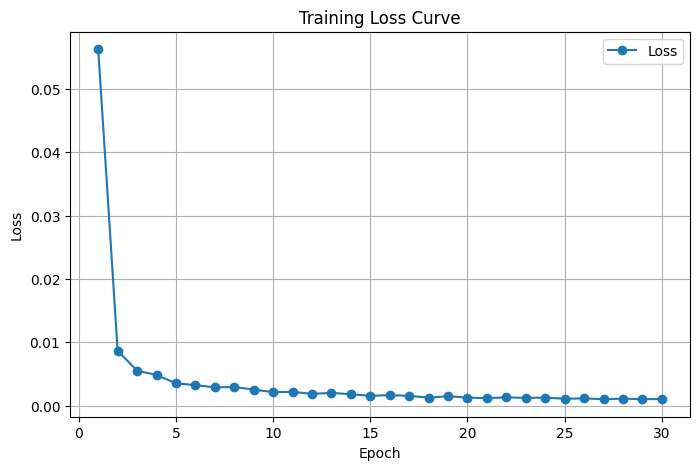

In [20]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

# ---------------------------
# Configuration Settings
# ---------------------------
config = {
    "batch_size": 16,
    "epochs": 30,  # Adjust as needed
    "learning_rate": 1e-4,
    "num_timesteps": 1000,
    "dm_file": "/content/Maps_Mcdm_Astrid_LH_z=0.00.npy",  # Path to DM map for training
    "model_save_path": "./conditional_final.pt",
    "image_size": 64,
    "conditioning_channels": 2,
    "target_channels": 1,
    "g1_file": "./g1.npy",  # Path to shear map g1 for training
    "g2_file": "./g2.npy",  # Path to shear map g2 for training
    "mass_file": "/content/Maps_Mtot_Astrid_LH_z=0.00.npy" # Path to mass map for training
}

# Set device for computations (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ---------------------------
# Mass-to-Shear Conversion
# ---------------------------
def mass_to_shear_optimized(mass, dtype=torch.float32):
     """
    Compute shear maps (g1, g2) from a mass map using GPU-accelerated FFT operations.

    Args:
        mass (np.ndarray): Input mass map.
        dtype (torch.dtype): Data type for computations.

    Returns:
        g1, g2 (np.ndarray): Shear maps.
    """
    # Normalize mass map for kappa computation
    mean_val = mass.mean()
    kappa = (mass - mean_val) / mean_val

    kappa = torch.tensor(kappa, dtype=dtype, device=device)  # Move to GPU
    ny, nx = kappa.shape
    sy, sx = ny * 2 - 1, nx * 2 - 1
    kappa_fft = torch.fft.fft2(kappa, s=(sy, sx))

    # Prepare frequency grids
    fy = torch.fft.fftfreq(sy, device=device)
    fx = torch.fft.fftfreq(sx, device=device)
    fy, fx = torch.meshgrid(fy, fx, indexing='ij')

    denom = (fx * fx + fy * fy)
    denom[0,0] = torch.inf  # Avoid division by zero
    kernel_1 = (fy * fy - fx * fx) / denom
    kernel_2 = 2 * fx * fy / denom

    g1 = torch.fft.ifft2(kappa_fft * kernel_1).real[:ny, :nx].cpu().numpy()  # back to CPU
    g2 = torch.fft.ifft2(kappa_fft * kernel_2).real[:ny, :nx].cpu().numpy()

    return g1, g2

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------
class DMConditioningDataset(Dataset):
    """
      Custom PyTorch Dataset for loading dark matter maps and generating corresponding shear maps.

      Args:
          dm_file (str): Path to the dark matter map file (NumPy format).
          mass_file (str): Path to the mass map file (NumPy format).
          dm_transform (callable, optional): Transform to apply to dark matter maps.
          shear_transform (callable, optional): Transform to apply to shear maps.
      """
    def __init__(self, dm_file, mass_file, dm_transform=None, shear_transform=None):
        print("[DEBUG] Loading DM data...")
        self.dm_data = np.load(dm_file, mmap_mode="r")  # DM data
        print("[DEBUG] DM data loaded with shape:", self.dm_data.shape)
        self.mass_data = np.load(mass_file, mmap_mode="r")  # Mass data

        self.dm_transform = dm_transform
        self.shear_transform = shear_transform
        self.shear_height, self.shear_width = config["image_size"], config["image_size"]
        print(f"[DEBUG] Shear/DM map size set to: ({self.shear_height}, {self.shear_width})")

    def __len__(self):
        length = len(self.dm_data)
        print("[DEBUG] Dataset length:", length)
        return length

    def __getitem__(self, idx):
        dm_map = self.dm_data[idx]  # (H,W)
        mass_map = self.mass_data[idx]  # (H,W)
        g1, g2 = mass_to_shear_optimized(mass_map)
        # g1, g2 = g1 * 256, g2 * 256

        # Convert to torch
        dm_map = torch.tensor(dm_map, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        shear_map = np.stack([g1, g2], axis=0)  # (2,H,W)
        shear_map = torch.tensor(shear_map, dtype=torch.float32)

        # Resize transformations
        resize_transform = transforms.Resize((self.shear_height, self.shear_width))
        dm_map = resize_transform(dm_map)

        shear_resized = []
        for i in range(shear_map.size(0)):
            c = shear_map[i].unsqueeze(0)
            c = resize_transform(c)
            shear_resized.append(c)
        shear_map = torch.cat(shear_resized, dim=0)

        # Normalization transforms
        def norm_transform(x):
            min_val = torch.min(x)
            max_val = torch.max(x)
            if max_val == min_val:
                return x*0
            else:
                return ((x - min_val) / (max_val - min_val) - 0.5) * 2

        dm_map = norm_transform(dm_map) if self.dm_transform is None else self.dm_transform(dm_map)

        return dm_map, shear_map

###########################################
# CONDITIONAL UNET MODEL
###########################################
class ConditionalUNet(torch.nn.Module):
   """
    Conditional U-Net model for diffusion tasks.

    Args:
        conditioning_channels (int): Number of channels in the conditioning input.
        target_channels (int): Number of output channels.
        sample_size (int): Input image size.
    """
    def __init__(self, conditioning_channels=2, target_channels=1, sample_size=64):
        super(ConditionalUNet, self).__init__()
        print("[DEBUG] Initializing ConditionalUNet with sample_size =", sample_size)
        self.unet = UNet2DModel(
            sample_size=sample_size,
            in_channels=conditioning_channels + target_channels,
            out_channels=target_channels,
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
            block_out_channels=(48, 96, 192, 384),
            layers_per_block=2,
            norm_num_groups=8,
            act_fn="silu",
            attention_head_dim=8,
            add_attention=True,
        )

    def forward(self, x, t, condition):
        condition = condition.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, condition), dim=1)
        out = self.unet(x, t).sample
        return out

def train_model(model, dataloader, optimizer, noise_scheduler, epochs):
     """
    Function to train the conditional U-Net model.

    Args:
        model (nn.Module): Conditional U-Net model to be trained.
        dataloader (DataLoader): DataLoader providing training data.
        optimizer (torch.optim): Optimizer for training.
        noise_scheduler (DDPMScheduler): Diffusion noise scheduler.
        epochs (int): Number of training epochs.

    Returns:
        List[float]: List of average losses per epoch.
    """
    print("[DEBUG] Starting training...")
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        print(f"[DEBUG] Starting epoch {epoch+1}/{epochs}")
        for i, (dm_maps, shear_maps) in enumerate(dataloader):
            dm_maps, shear_maps = dm_maps.to(device), shear_maps.to(device)

            noise = torch.randn_like(dm_maps)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                      (dm_maps.size(0),), device=device).long()
            noisy_dm_maps = noise_scheduler.add_noise(dm_maps, noise, timesteps)

            pred_noise = model(noisy_dm_maps, timesteps, shear_maps)
            loss = torch.nn.MSELoss()(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"[DEBUG - Training] Step {i}, Loss: {loss.item():.6f}")

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")

    return epoch_losses

# Initialize dataset and dataloader
print("[DEBUG] Initializing dataset for training...")
train_dataset = DMConditioningDataset(
    dm_file=config["dm_file"],
    mass_file=config["mass_file"],
    dm_transform=None,
    shear_transform=None
)
train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

# Debug one batch
print("[DEBUG] Fetching one test batch (for debugging training)...")
dm_maps_test, shear_maps_test = next(iter(train_dataloader))
print(f"[TEST] One batch of dm_maps: {dm_maps_test.shape}, shear_maps: {shear_maps_test.shape}")

# Initialize model, optimizer, scheduler
sample_size = config["image_size"]
model = ConditionalUNet(conditioning_channels=2, target_channels=1, sample_size=sample_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_timesteps"])

print("[DEBUG] Running model on test batch for debugging training...")
dm_maps_test, shear_maps_test = dm_maps_test.to(device), shear_maps_test.to(device)
noise_test = torch.randn_like(dm_maps_test)
timesteps_test = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                               (dm_maps_test.size(0),), device=device).long()
noisy_dm_maps_test = noise_scheduler.add_noise(dm_maps_test, noise_test, timesteps_test)
with torch.no_grad():
    pred_noise_test = model(noisy_dm_maps_test, timesteps_test, shear_maps_test)
    print(f"[TEST] Model output shape on test batch: {pred_noise_test.shape}")

# Train the model
epoch_losses = train_model(model, train_dataloader, optimizer, noise_scheduler, config["epochs"])

# Save the Trained Model
print("[DEBUG] Saving model...")
torch.save(model.state_dict(), config["model_save_path"])
print(f"Model saved to {config['model_save_path']}")

# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.title("Training Loss Curve")
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


Inference on Real Shear Maps Data

[DEBUG] Initializing ConditionalUNet with sample_size = 64


<ipython-input-22-10e4bafea7d7>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/conditional_final.pt", map_location=device))


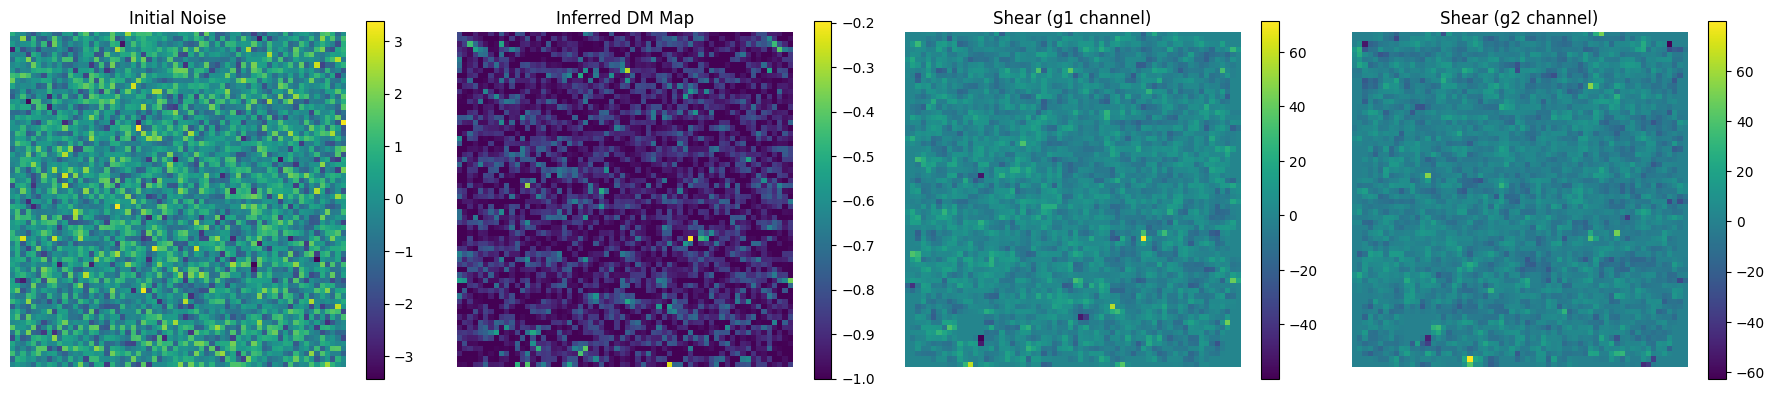

In [22]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import DDPMScheduler

# Ensure config and device are defined as in your training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained Conditional U-Net model and set to evaluation mode
model = ConditionalUNet(
    conditioning_channels=config["conditioning_channels"],
    target_channels=config["target_channels"],
    sample_size=config["image_size"]
).to(device)
model.load_state_dict(torch.load("/content/conditional_final.pt", map_location=device))
model.eval()

# Load shear map components (g1, g2) from files
g1_real = np.load(config["g1_file"])
g2_real = np.load(config["g2_file"])

# Convert to torch tensors
g1_t = torch.tensor(g1_real, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
g2_t = torch.tensor(g2_real, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

# Resize and normalize shear maps as in training
resize_transform = transforms.Resize((config["image_size"], config["image_size"]))

g1_t = resize_transform(g1_t)
g2_t = resize_transform(g2_t)

# Normalize shear maps if necessary (scaled by 256 in this example)
g1_t, g2_t = g1_t * 256, g2_t * 256


# Stack g1 and g2 to form shear_map (2,H,W)
shear_map = torch.cat([g1_t, g2_t], dim=0).unsqueeze(0)  # (B=1,2,64,64)
shear_map = shear_map.to(device)

# Create initial noise for DM map inference
shape = (1, 1, config["image_size"], config["image_size"])
initial_noise = torch.randn(shape, device=device)

x = initial_noise.clone()

# Initialize the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_timesteps"])

# Move scheduler parameters to GPU if needed
noise_scheduler.alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
if hasattr(noise_scheduler, 'betas'):
    noise_scheduler.betas = noise_scheduler.betas.to(device)

# Perform reverse diffusion steps
with torch.no_grad():
    for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
        step = torch.tensor([t], dtype=torch.long, device=device)
        pred_noise = model(x, step, shear_map)
        x = noise_scheduler.step(pred_noise, step, x).prev_sample

# x now should be the denoised DM map
dm_inferred = x[0,0].cpu().numpy()

plt.figure(figsize=(18, 4))

# Initial Noise
plt.subplot(1, 4, 1)
plt.title("Initial Noise")
plt.imshow(initial_noise[0, 0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

# Inferred DM Map
plt.subplot(1, 4, 2)
plt.title("Inferred DM Map")
plt.imshow(dm_inferred, cmap='viridis')
plt.colorbar()
plt.axis('off')

# Shear g1 channel
plt.subplot(1, 4, 3)
plt.title("Shear (g1 channel)")
plt.imshow(g1_t[0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

# Shear g2 channel
plt.subplot(1, 4, 4)
plt.title("Shear (g2 channel)")
plt.imshow(g2_t[0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


Inference with Gaussian Filtering on Real Data

[DEBUG] Initializing ConditionalUNet with sample_size = 64


<ipython-input-21-44a8c2e5dd01>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/conditional_final.pt", map_location=device))


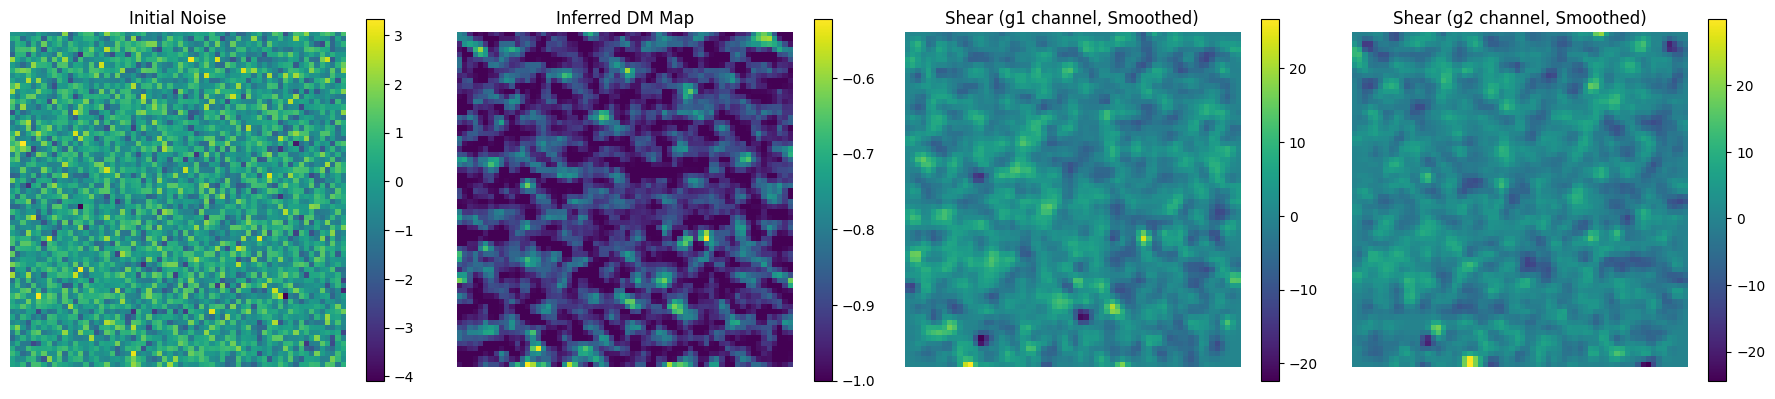

In [21]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import DDPMScheduler
from scipy.ndimage import gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = ConditionalUNet(
    conditioning_channels=config["conditioning_channels"],
    target_channels=config["target_channels"],
    sample_size=config["image_size"]
).to(device)
model.load_state_dict(torch.load("/content/conditional_final.pt", map_location=device))
model.eval()

# Load real g1 and g2 from files
g1_real = np.load("/content/g1.npy")  # shape: (H,W)
g2_real = np.load("/content/g2.npy")  # shape: (H,W)

# Apply Gaussian smoothing to g1 and g2
sigma = 1.0  # Adjust this parameter to control the level of smoothing
g1_smoothed = gaussian_filter(g1_real, sigma=sigma)
g2_smoothed = gaussian_filter(g2_real, sigma=sigma)

# Convert to torch tensors
g1_t = torch.tensor(g1_smoothed, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
g2_t = torch.tensor(g2_smoothed, dtype=torch.float32).unsqueeze(0)  # (1,H,W)

# Resize and normalize shear maps as in training
resize_transform = transforms.Resize((config["image_size"], config["image_size"]))

g1_t = resize_transform(g1_t)  # (1,64,64)
g2_t = resize_transform(g2_t)  # (1,64,64)

# If you were scaling by a factor (like *256), do that here:
g1_t, g2_t = g1_t * 256, g2_t * 256

# Stack g1 and g2 to form shear_map (2,H,W)
shear_map = torch.cat([g1_t, g2_t], dim=0).unsqueeze(0)  # (B=1,2,64,64)
shear_map = shear_map.to(device)

# Create initial noise for DM map inference
shape = (1, 1, config["image_size"], config["image_size"])
initial_noise = torch.randn(shape, device=device)

x = initial_noise.clone()

# Initialize the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=config["num_timesteps"])

# Move scheduler parameters to GPU if needed
noise_scheduler.alphas_cumprod = noise_scheduler.alphas_cumprod.to(device)
if hasattr(noise_scheduler, 'betas'):
    noise_scheduler.betas = noise_scheduler.betas.to(device)

# Perform reverse diffusion steps
with torch.no_grad():
    for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
        step = torch.tensor([t], dtype=torch.long, device=device)
        pred_noise = model(x, step, shear_map)
        x = noise_scheduler.step(pred_noise, step, x).prev_sample

# x now should be the denoised DM map
dm_inferred = x[0,0].cpu().numpy()

plt.figure(figsize=(18, 4))  # Adjust the figure size for better layout

# Initial Noise
plt.subplot(1, 4, 1)
plt.title("Initial Noise")
plt.imshow(initial_noise[0, 0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

# Inferred DM Map
plt.subplot(1, 4, 2)
plt.title("Inferred DM Map")
plt.imshow(dm_inferred, cmap='viridis')
plt.colorbar()
plt.axis('off')

# Shear g1 channel (Smoothed)
plt.subplot(1, 4, 3)
plt.title("Shear (g1 channel, Smoothed)")
plt.imshow(g1_t[0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

# Shear g2 channel (Smoothed)
plt.subplot(1, 4, 4)
plt.title("Shear (g2 channel, Smoothed)")
plt.imshow(g2_t[0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()
